Intrusion Detection with the UNSW-NB15 Dataset

In [1]:
# --- 1. Import libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# For pretty plots
sns.set(style="whitegrid", font_scale=1.1)

In [2]:
# --- 2. Load the dataset (training + testing sets) ---
train = pd.read_csv("/UNSW_NB15_training-set.csv")
test  = pd.read_csv("/UNSW_NB15_testing-set.csv")

df = pd.concat([train, test], ignore_index=True)

print("Dataset loaded successfully!")
print("Shape of combined data:", df.shape)
print()


Dataset loaded successfully!
Shape of combined data: (257673, 45)



=== Dataset Information ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              2576

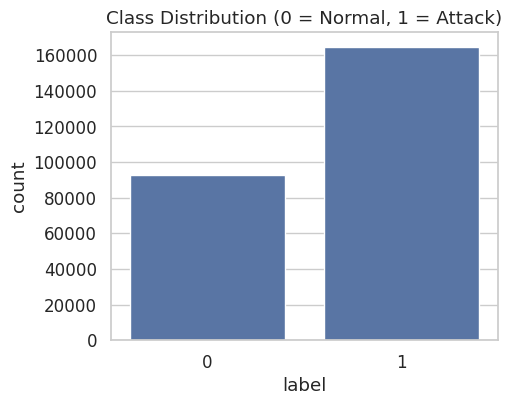

In [3]:
# --- 3. Basic descriptive analysis ---
print("=== Dataset Information ===")
df.info()
print("\n=== Missing Values (total) ===")
print(df.isna().sum().sum())

print("\n=== Class Distribution (label) ===")
print(df['label'].value_counts())

print("\n=== Attack Categories ===")
print(df['attack_cat'].value_counts())

plt.figure(figsize=(5, 4))
sns.countplot(x='label', data=df)
plt.title("Class Distribution (0 = Normal, 1 = Attack)")
plt.show()


Dimensions after basic cleaning: (257673, 37)

Columns dropped for high correlation: ['sbytes', 'dbytes', 'sloss', 'dloss', 'dwin', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'ct_srv_dst']
Final dimensions: (257673, 29)


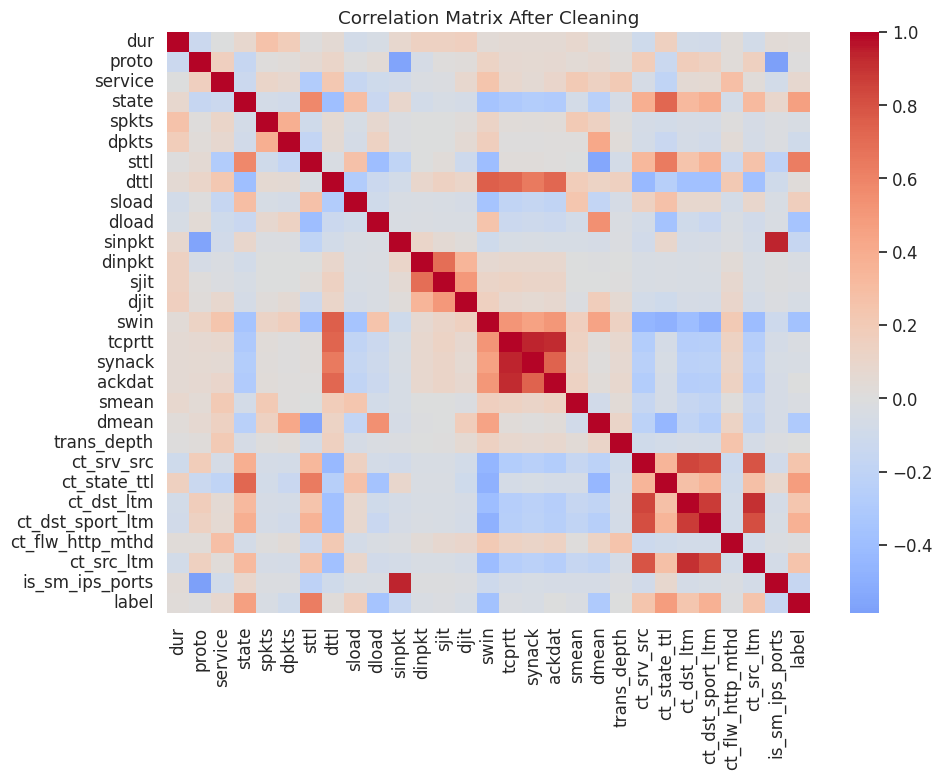


Cleaning and preprocessing completed successfully.


In [4]:
# 4. CLEANING & PREPROCESSING

df_clean = df.copy()

# ---- Encode categorical variables ----
enc = LabelEncoder()
for col in ['proto', 'service', 'state', 'attack_cat']:
    df_clean[col] = enc.fit_transform(df_clean[col])

# ---- Drop clearly useless or problematic columns ----
cols_to_drop = [
    'id',               # row identifier
    'attack_cat',       # high risk of label leakage if we only predict 'label'
    'stcpb', 'dtcpb',   # TCP sequence numbers
    'response_body_len',
    'ct_ftp_cmd',
    'is_ftp_login',
    'rate'
]
df_clean = df_clean.drop(columns=cols_to_drop, errors='ignore')

print("\nDimensions after basic cleaning:", df_clean.shape)

# ---- Optional: Outlier detection ----
"""
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
outlier_indices = set()

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    mask = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
    outlier_indices.update(df_clean[mask].index)

print(f"Detected {len(outlier_indices)} potential outliers.")
# df_clean = df_clean.drop(index=outlier_indices)
# print("Dimensions after outlier removal:", df_clean.shape)
"""

# ---- Remove highly correlated features (|corr| > 0.95) ----
corr_matrix = df_clean.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_corr = [c for c in upper.columns if any(upper[c] > 0.95)]

df_clean = df_clean.drop(columns=to_drop_corr, errors='ignore')
print("\nColumns dropped for high correlation:", to_drop_corr)
print("Final dimensions:", df_clean.shape)

# ---- Correlation heatmap (optional) ----
plt.figure(figsize=(10, 8))
sns.heatmap(df_clean.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix After Cleaning")
plt.tight_layout()
plt.show()

print("\nCleaning and preprocessing completed successfully.")

In [5]:
# 5. DEFINE FEATURES / TARGET + TRAIN/TEST SPLIT

X = df_clean.drop(columns=['label'])
y = df_clean['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("\nTraining size:", X_train.shape)
print("Testing size:", X_test.shape)


Training size: (180371, 28)
Testing size: (77302, 28)


In [6]:
# 6. SCALE FEATURES

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("\nData scaling completed.")


Data scaling completed.


In [7]:
# 7. BASELINE MODEL — RANDOM FOREST

rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_baseline.fit(X_train_scaled, y_train)
y_pred_base = rf_baseline.predict(X_test_scaled)

print("\n=== Baseline Random Forest ===")
print(classification_report(y_test, y_pred_base))


=== Baseline Random Forest ===
              precision    recall  f1-score   support

           0       0.94      0.84      0.89     27900
           1       0.92      0.97      0.94     49402

    accuracy                           0.92     77302
   macro avg       0.93      0.91      0.91     77302
weighted avg       0.92      0.92      0.92     77302



In [8]:
# 8. GRID SEARCH — OPTIMIZED RANDOM FOREST (PART II)

param_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True, False]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_rf,
    scoring="f1",
    cv=2,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_scaled, y_train)

print("\n=== GridSearchCV — Random Forest ===")
print("Best parameters:", grid_rf.best_params_)
print("Best CV F1:", grid_rf.best_score_)

y_pred_rf_opt = grid_rf.predict(X_test_scaled)
print("\n=== Optimized Random Forest ===")
print(classification_report(y_test, y_pred_rf_opt))

Fitting 2 folds for each of 48 candidates, totalling 96 fits

=== GridSearchCV — Random Forest ===
Best parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV F1: 0.9501920094253886

=== Optimized Random Forest ===
              precision    recall  f1-score   support

           0       0.92      0.92      0.92     27900
           1       0.96      0.95      0.95     49402

    accuracy                           0.94     77302
   macro avg       0.94      0.94      0.94     77302
weighted avg       0.94      0.94      0.94     77302



In [9]:
# 9. BAGGING ENSEMBLE (RF AS BASE ESTIMATOR)

bag_rf = BaggingClassifier(
    estimator=grid_rf.best_estimator_,
    n_estimators=10,
    max_samples=0.8,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

bag_rf.fit(X_train_scaled, y_train)
y_pred_bag = bag_rf.predict(X_test_scaled)

print("\n=== Bagging (Random Forest) ===")
print(classification_report(y_test, y_pred_bag))


=== Bagging (Random Forest) ===
              precision    recall  f1-score   support

           0       0.91      0.92      0.92     27900
           1       0.95      0.95      0.95     49402

    accuracy                           0.94     77302
   macro avg       0.93      0.94      0.94     77302
weighted avg       0.94      0.94      0.94     77302



In [10]:
# 10. VOTING ENSEMBLE (RF + LOGISTIC REGRESSION + SVM)

log_reg = LogisticRegression(max_iter=2000, n_jobs=-1)
svm = SVC(kernel="rbf", probability=True, random_state=42)

voting = VotingClassifier(
    estimators=[
        ("rf", grid_rf.best_estimator_),
        ("lr", log_reg),
        ("svm", svm)
    ],
    voting="soft"  # soft = average probabilities
)

voting.fit(X_train_scaled, y_train)
y_pred_vote = voting.predict(X_test_scaled)

print("\n=== Voting Ensemble (RF + LR + SVM) ===")
print(classification_report(y_test, y_pred_vote))


=== Voting Ensemble (RF + LR + SVM) ===
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     27900
           1       0.92      0.96      0.94     49402

    accuracy                           0.92     77302
   macro avg       0.92      0.91      0.91     77302
weighted avg       0.92      0.92      0.92     77302



In [12]:
# 11. METRIC SUMMARY TABLE

def metrics_for(y_true, y_pred, name):
    return {
        "Model": name,
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall":    recall_score(y_true, y_pred),
        "F1-score":  f1_score(y_true, y_pred)
    }

results = []
results.append(metrics_for(y_test, y_pred_base,   "Baseline RF"))
results.append(metrics_for(y_test, y_pred_rf_opt, "Optimized RF"))
results.append(metrics_for(y_test, y_pred_bag,    "Bagging RF"))
results.append(metrics_for(y_test, y_pred_vote,   "Voting Ensemble"))

results_df = pd.DataFrame(results)
print("\n=== Model Comparison ===")
print(results_df)


=== Model Comparison ===
             Model  Accuracy  Precision    Recall  F1-score
0      Baseline RF  0.923288   0.916351  0.968362  0.941638
1     Optimized RF  0.941696   0.956668  0.951885  0.954270
2       Bagging RF  0.940118   0.954484  0.951682  0.953081
3  Voting Ensemble  0.921826   0.917838  0.963969  0.940338


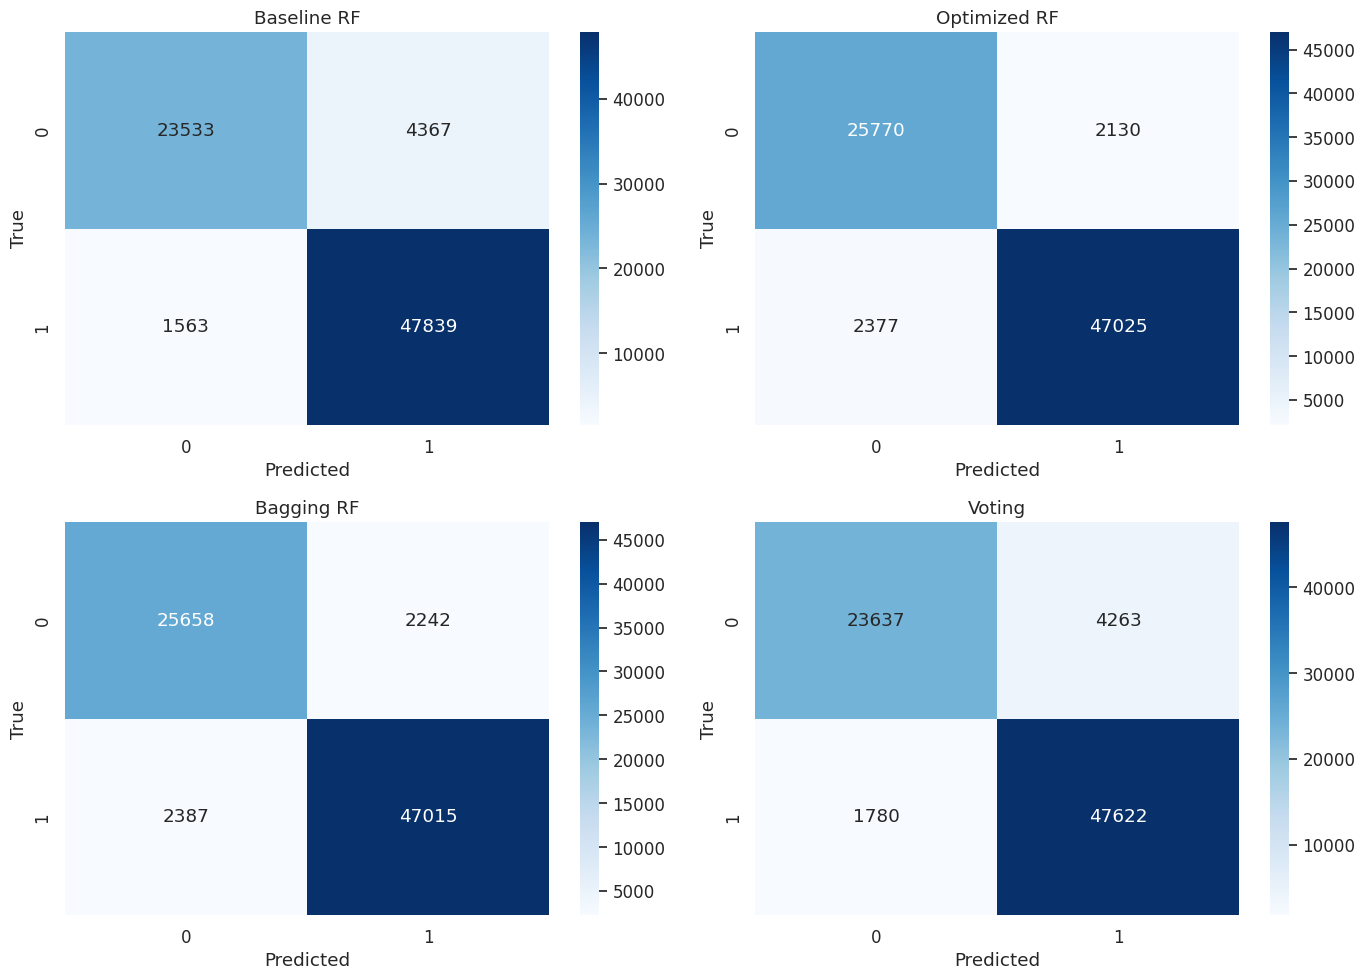

In [13]:
# 12. CONFUSION MATRICES

models_preds = {
    "Baseline RF":   y_pred_base,
    "Optimized RF":  y_pred_rf_opt,
    "Bagging RF":    y_pred_bag,
    "Voting":        y_pred_vote
}

plt.figure(figsize=(14, 10))
for i, (name, preds) in enumerate(models_preds.items(), 1):
    plt.subplot(2, 2, i)
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("True")
plt.tight_layout()
plt.show()

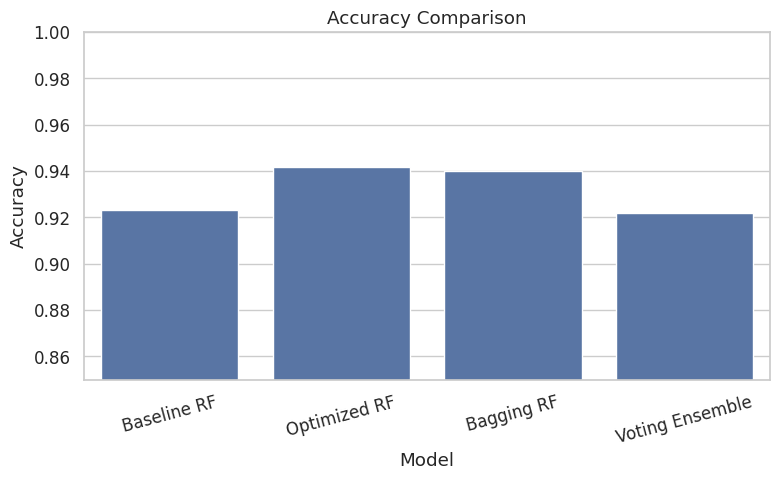

In [14]:
# 13. ACCURACY BAR CHART

plt.figure(figsize=(8, 5))
sns.barplot(x=results_df["Model"], y=results_df["Accuracy"])
plt.ylim(0.85, 1.0)
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

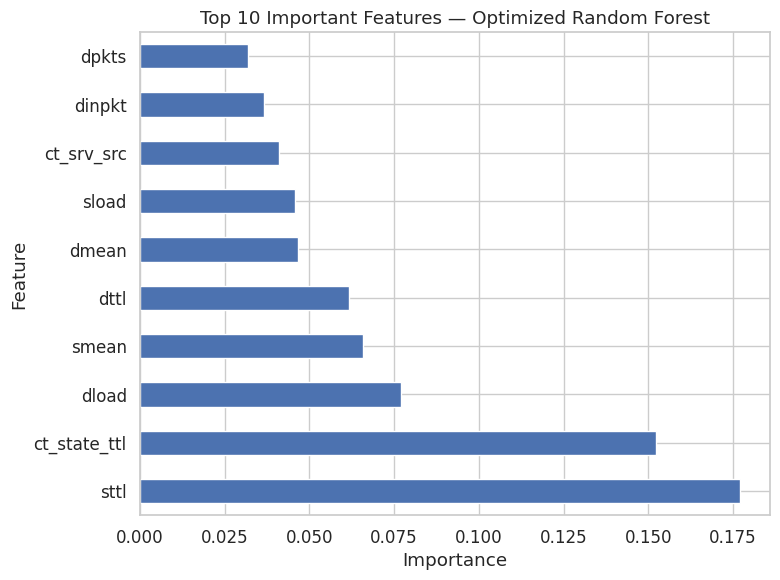

In [15]:
# 14. FEATURE IMPORTANCE (FROM OPTIMIZED RF)

importances = pd.Series(
    grid_rf.best_estimator_.feature_importances_,
    index=X.columns
)

plt.figure(figsize=(8, 6))
importances.nlargest(10).plot(kind="barh")
plt.title("Top 10 Important Features — Optimized Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Part 3: Plus

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import roc_curve

# --- Build the MLP Model ---
mlp = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

mlp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# --- Train the MLP ---
history_mlp = mlp.fit(
    X_train_scaled, y_train,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# --- Evaluate ---
y_pred_mlp = (mlp.predict(X_test_scaled) > 0.5).astype(int)

print("\n=== MLP Neural Network Classifier ===")
print(classification_report(y_test, y_pred_mlp))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8668 - loss: 0.2983 - precision_1: 0.8666 - recall_1: 0.9355 - val_accuracy: 0.9068 - val_loss: 0.1807 - val_precision_1: 0.8958 - val_recall_1: 0.9656
Epoch 2/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9024 - loss: 0.1890 - precision_1: 0.8979 - recall_1: 0.9564 - val_accuracy: 0.9122 - val_loss: 0.1704 - val_precision_1: 0.9070 - val_recall_1: 0.9601
Epoch 3/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9064 - loss: 0.1799 - precision_1: 0.9026 - recall_1: 0.9562 - val_accuracy: 0.9118 - val_loss: 0.1649 - val_precision_1: 0.9076 - val_recall_1: 0.9586
Epoch 4/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9082 - loss: 0.1725 - precision_1: 0.9078 - recall_1: 0.9539 - val_accuracy: 0.9123 - val_loss: 0.1618 - val_precision_1: 0.9167 - val_recall_1: 0.9480
Epoch 5/10
564/564 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9108 - loss: 0.1674 - precision_1: 0.9125 - recall_1: 0.9515 

In [17]:
# 1) Use only NORMAL traffic for training (label = 0)
X_normal = X_train_scaled[y_train == 0]
input_dim = X_train_scaled.shape[1]

# 2) Build a deeper Autoencoder
autoencoder = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')

# 3) Train Autoencoder on NORMAL data only
history_ae = autoencoder.fit(
    X_normal, X_normal,
    epochs=10,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# 4) Compute reconstruction errors on TEST set
recon = autoencoder.predict(X_test_scaled)
errors = np.mean(np.square(recon - X_test_scaled), axis=1)

# 5) Find best threshold using ROC curve (Youden's J statistic)
fpr, tpr, thresholds = roc_curve(y_test, errors)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print("Best ROC threshold:", best_threshold)

# 6) Classify: error > threshold -> ATTACK (1), else NORMAL (0)
y_pred_ae = (errors > best_threshold).astype(int)

print("\n=== Autoencoder (Deeper, ROC-Optimized Threshold) ===")
print(classification_report(y_test, y_pred_ae))

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5753 - val_loss: 0.0315
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0281 - val_loss: 0.0166
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146 - val_loss: 0.0089
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0101 - val_loss: 0.0069
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0062 - val_loss: 0.0070
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0053 - val_loss: 0.0057
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 10/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - val_loss: 0.0029
2416/2416 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Best ROC threshold: 0.004552941905004222

=== Autoencoder (Deeper, ROC-Optimized Threshold) ===
           

In [18]:
# Reshape input for LSTM: (samples, timesteps=1, features)
X_train_lstm = X_train_scaled.reshape((-1, 1, X_train_scaled.shape[1]))
X_test_lstm  = X_test_scaled.reshape((-1, 1, X_test_scaled.shape[1]))

# --- Build LSTM Model ---
lstm = models.Sequential([
    layers.LSTM(64, return_sequences=False, input_shape=(1, X_train_scaled.shape[1])),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# --- Train LSTM ---
history_lstm = lstm.fit(
    X_train_lstm, y_train,
    epochs=5,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

# --- Evaluate ---
y_pred_lstm = (lstm.predict(X_test_lstm) > 0.5).astype(int)

print("\n=== LSTM Classifier ===")
print(classification_report(y_test, y_pred_lstm))

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


564/564 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8542 - loss: 0.3403 - precision_2: 0.8641 - recall_2: 0.9145 - val_accuracy: 0.9060 - val_loss: 0.1842 - val_precision_2: 0.9015 - val_recall_2: 0.9565
Epoch 2/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9041 - loss: 0.1880 - precision_2: 0.9000 - recall_2: 0.9569 - val_accuracy: 0.9090 - val_loss: 0.1747 - val_precision_2: 0.8974 - val_recall_2: 0.9671
Epoch 3/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9069 - loss: 0.1776 - precision_2: 0.9035 - recall_2: 0.9571 - val_accuracy: 0.9099 - val_loss: 0.1689 - val_precision_2: 0.9085 - val_recall_2: 0.9541
Epoch 4/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9081 - loss: 0.1735 - precision_2: 0.9073 - recall_2: 0.9540 - val_accuracy: 0.9088 - val_loss: 0.1680 - val_precision_2: 0.8986 - val_recall_2: 0.9653
Epoch 5/5
564/564 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9092 - loss: 0.1696 - precision_2: 0.9076 - recall_2: 0.9554 - val_accuracy: 

In [19]:
results_dl = pd.DataFrame([
    metrics_for(y_test, y_pred_mlp,  "MLP Neural Network"),
    metrics_for(y_test, y_pred_ae,   "Autoencoder (Anomaly Detection)"),
    metrics_for(y_test, y_pred_lstm, "LSTM Classifier")
])

print("\n=== Deep Learning Model Comparison ===")
print(results_dl)



=== Deep Learning Model Comparison ===
                             Model  Accuracy  Precision    Recall  F1-score
0               MLP Neural Network  0.919782   0.925567  0.950953  0.938088
1  Autoencoder (Anomaly Detection)  0.805387   0.941642  0.741427  0.829626
2                  LSTM Classifier  0.914711   0.919031  0.950265  0.934387


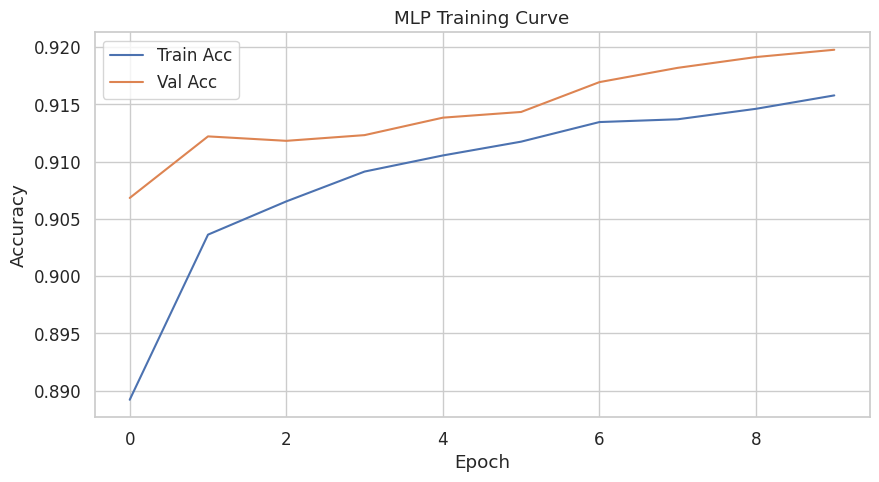

In [20]:
plt.figure(figsize=(10,5))
plt.plot(history_mlp.history['accuracy'], label='Train Acc')
plt.plot(history_mlp.history['val_accuracy'], label='Val Acc')
plt.title("MLP Training Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The objective of this project is to build a machine-learning model capable of classifying incoming
network packets as either malicious (1) or benign (0) using the UNSW-NB15 dataset. Each record
describes a network flow through 44 numerical and categorical features such as protocol type,
byte counts, and connection flags. The task is a supervised binary classification problem: Inputs
(X): the network traffic features. Output (y): the binary label label (0 = normal, 1 = attack). The
baseline model used is a Random Forest Classifier, achieving an accuracy of 95 %, precision
0.96, recall 0.96, and F1-score 0.96. These results indicate that the model successfully detects
malicious network behavior with high reliability.